In [273]:
import pandas as pd
import numpy as np
import time
from sklearn.feature_selection import SelectFromModel
from xgboost import XGBRegressor

pd.set_option('max_columns', None)

In [262]:
matrix = pd.read_csv('matrix.csv')
#matrix = pd.read_csv('matrix_ce_targetencoding.csv')
matrix = pd.concat([matrix,pd.get_dummies(matrix['type_big'], prefix='type_big')],axis=1)
for col in matrix.select_dtypes('object'):
    matrix = matrix.drop([col], axis=1)
for col in matrix.select_dtypes(np.float64):
    matrix[col] = matrix[col].astype(np.float32)
matrix.head(3)

,amount_month_sum,date_block_num,season_block,store_id,transacted_month,transacted_year,encoding_region_big,encoding_region_detail,encoding_type_big,date_type_big_avg_amount_lag_3,date_type_big_avg_amount_lag_4,date_type_big_avg_amount_lag_5,date_type_big_avg_amount_lag_6,date_type_big_avg_amount_lag_12,date_type_big_avg_amount_lag_13,date_type_big_avg_amount_lag_14,date_type_big_avg_amount_lag_24,date_type_big_avg_amount_lag_25,date_region_big_avg_amount_lag_3,date_region_big_avg_amount_lag_4,date_region_big_avg_amount_lag_5,date_region_big_avg_amount_lag_6,date_region_big_avg_amount_lag_12,date_region_big_avg_amount_lag_13,date_region_big_avg_amount_lag_14,date_region_big_avg_amount_lag_24,date_region_big_avg_amount_lag_25,date_region_detail_avg_amount_lag_3,date_region_detail_avg_amount_lag_4,date_region_detail_avg_amount_lag_5,date_region_detail_avg_amount_lag_6,date_region_detail_avg_amount_lag_12,date_region_detail_avg_amount_lag_13,date_region_detail_avg_amount_lag_14,date_region_detail_avg_amount_lag_24,date_region_detail_avg_amount_lag_25,delta_amount_avg_lag_3,delta_amount_avg_lag_4,delta_amount_avg_lag_5,delta_amount_avg_lag_6,delta_amount_avg_lag_12,delta_amount_avg_lag_13,delta_amount_avg_lag_14,delta_amount_avg_lag_24,delta_amount_avg_lag_25,amount_month_sum_lag_3,amount_month_sum_lag_4,amount_month_sum_lag_5,amount_month_sum_lag_6,amount_month_sum_lag_12,amount_month_sum_lag_13,amount_month_sum_lag_14,amount_month_sum_lag_24,amount_month_sum_lag_25,a_lag_3,a_lag_4,a_lag_5,a_lag_6,a_lag_12,a_lag_13,a_lag_14,a_lag_24,a_lag_25,b_lag_3,b_lag_4,b_lag_5,b_lag_6,b_lag_12,b_lag_13,b_lag_14,b_lag_24,b_lag_25,c_lag_3,c_lag_4,c_lag_5,c_lag_6,c_lag_12,c_lag_13,c_lag_14,c_lag_24,c_lag_25,d_lag_3,d_lag_4,d_lag_5,d_lag_6,d_lag_12,d_lag_13,d_lag_14,d_lag_24,d_lag_25,e_lag_3,e_lag_4,e_lag_5,e_lag_6,e_lag_12,e_lag_13,e_lag_14,e_lag_24,e_lag_25,f_lag_3,f_lag_4,f_lag_5,f_lag_6,f_lag_12,f_lag_13,f_lag_14,f_lag_24,f_lag_25,g_lag_3,g_lag_4,g_lag_5,g_lag_6,g_lag_12,g_lag_13,g_lag_14,g_lag_24,g_lag_25,h_lag_3,h_lag_4,h_lag_5,h_lag_6,h_lag_12,h_lag_13,h_lag_14,h_lag_24,h_lag_25,card_company_a_avg_lag_3,card_company_a_avg_lag_4,card_company_a_avg_lag_5,card_company_a_avg_lag_6,card_company_a_avg_lag_12,card_company_a_avg_lag_13,card_company_a_avg_lag_14,card_company_a_avg_lag_24,card_company_a_avg_lag_25,card_company_b_avg_lag_3,card_company_b_avg_lag_4,card_company_b_avg_lag_5,card_company_b_avg_lag_6,card_company_b_avg_lag_12,card_company_b_avg_lag_13,card_company_b_avg_lag_14,card_company_b_avg_lag_24,card_company_b_avg_lag_25,card_company_c_avg_lag_3,card_company_c_avg_lag_4,card_company_c_avg_lag_5,card_company_c_avg_lag_6,card_company_c_avg_lag_12,card_company_c_avg_lag_13,card_company_c_avg_lag_14,card_company_c_avg_lag_24,card_company_c_avg_lag_25,card_company_d_avg_lag_3,card_company_d_avg_lag_4,card_company_d_avg_lag_5,card_company_d_avg_lag_6,card_company_d_avg_lag_12,card_company_d_avg_lag_13,card_company_d_avg_lag_14,card_company_d_avg_lag_24,card_company_d_avg_lag_25,card_company_e_avg_lag_3,card_company_e_avg_lag_4,card_company_e_avg_lag_5,card_company_e_avg_lag_6,card_company_e_avg_lag_12,card_company_e_avg_lag_13,card_company_e_avg_lag_14,card_company_e_avg_lag_24,card_company_e_avg_lag_25,card_company_f_avg_lag_3,card_company_f_avg_lag_4,card_company_f_avg_lag_5,card_company_f_avg_lag_6,card_company_f_avg_lag_12,card_company_f_avg_lag_13,card_company_f_avg_lag_14,card_company_f_avg_lag_24,card_company_f_avg_lag_25,card_company_g_avg_lag_3,card_company_g_avg_lag_4,card_company_g_avg_lag_5,card_company_g_avg_lag_6,card_company_g_avg_lag_12,card_company_g_avg_lag_13,card_company_g_avg_lag_14,card_company_g_avg_lag_24,card_company_g_avg_lag_25,card_company_h_avg_lag_3,card_company_h_avg_lag_4,card_company_h_avg_lag_5,card_company_h_avg_lag_6,card_company_h_avg_lag_12,card_company_h_avg_lag_13,card_company_h_avg_lag_14,card_company_h_avg_lag_24,card_company_h_avg_lag_25,transacted_month_1,transacted_month_2,transacted_month_3

In [263]:
matrix = matrix.drop([col for col in matrix.columns if 'delta' in col], axis=1)
#matrix = matrix.drop([col for col in matrix.columns if 'amount_month_sum_lag' in col], axis=1)
#matrix = matrix.drop([col for col in matrix.columns if 'card_company' in col], axis=1)
#matrix = matrix.drop([col for col in matrix.columns if '_term_total' in col], axis=1)
#matrix = matrix.drop([col for col in matrix.columns if '_term_lag' in col], axis=1)

In [264]:
'''
for tmp in ['a', 'b', 'c', 'd', 'e', 'f' ,'g', 'h']:
    for lag in [3, 4, 5, 6, 12, 13, 14, 24, 25]:
        matrix = matrix.drop(['{}_lag_{}'.format(tmp, lag)], axis=1)
'''

"\nfor tmp in ['a', 'b', 'c', 'd', 'e', 'f' ,'g', 'h']:\n    for lag in [3, 4, 5, 6, 12, 13, 14, 24, 25]:\n        matrix = matrix.drop(['{}_lag_{}'.format(tmp, lag)], axis=1)\n"

In [265]:
matrix = pd.concat([matrix,pd.get_dummies(matrix['transacted_year'], prefix='transacted_year')],axis=1)

In [266]:
matrix = matrix.drop(['season_block', 'transacted_month', 'transacted_year', 'encoding_region_big'], axis=1)

In [286]:
X_train = matrix[matrix.date_block_num < 32].drop(['amount_month_sum'], axis=1)
Y_train = matrix[matrix.date_block_num < 32]['amount_month_sum']
X_valid = matrix[matrix.date_block_num == 32].drop(['amount_month_sum'], axis=1)
Y_valid = matrix[matrix.date_block_num == 32]['amount_month_sum']
#X_test = matrix[data.date_block_num == 34].drop(['item_cnt_month'], axis=1)
#Y_train = np.log1p(Y_train)
#Y_valid = np.log1p(Y_valid)

ts = time.time()
model = XGBRegressor(
    max_depth=12,
    n_estimators=1000,
    min_child_weight=17, 
    colsample_bytree=0.9, 
    subsample=0.9, 
    eta=0.1,    
    seed=42)

model.fit(
    X_train, 
    Y_train, 
    eval_metric="mae", 
    eval_set=[(X_train, Y_train), (X_valid, Y_valid)], 
    verbose=True, 
    early_stopping_rounds = 5)

time.time() - ts

[0]	validation_0-mae:1.05312e+06	validation_1-mae:899867
Multiple eval metrics have been passed: 'validation_1-mae' will be used for early stopping.

Will train until validation_1-mae hasn't improved in 5 rounds.
[1]	validation_0-mae:953056	validation_1-mae:803667
[2]	validation_0-mae:865056	validation_1-mae:720592
[3]	validation_0-mae:788043	validation_1-mae:646364
[4]	validation_0-mae:720357	validation_1-mae:584650
[5]	validation_0-mae:661067	validation_1-mae:528696
[6]	validation_0-mae:609077	validation_1-mae:483419
[7]	validation_0-mae:564156	validation_1-mae:445504
[8]	validation_0-mae:525448	validation_1-mae:412674
[9]	validation_0-mae:492212	validation_1-mae:386632
[10]	validation_0-mae:463794	validation_1-mae:365958
[11]	validation_0-mae:439470	validation_1-mae:348769
[12]	validation_0-mae:418869	validation_1-mae:335523
[13]	validation_0-mae:401322	validation_1-mae:325743
[14]	validation_0-mae:386536	validation_1-mae:318160
[15]	validation_0-mae:373819	validation_1-mae:312126
[

27.814122438430786

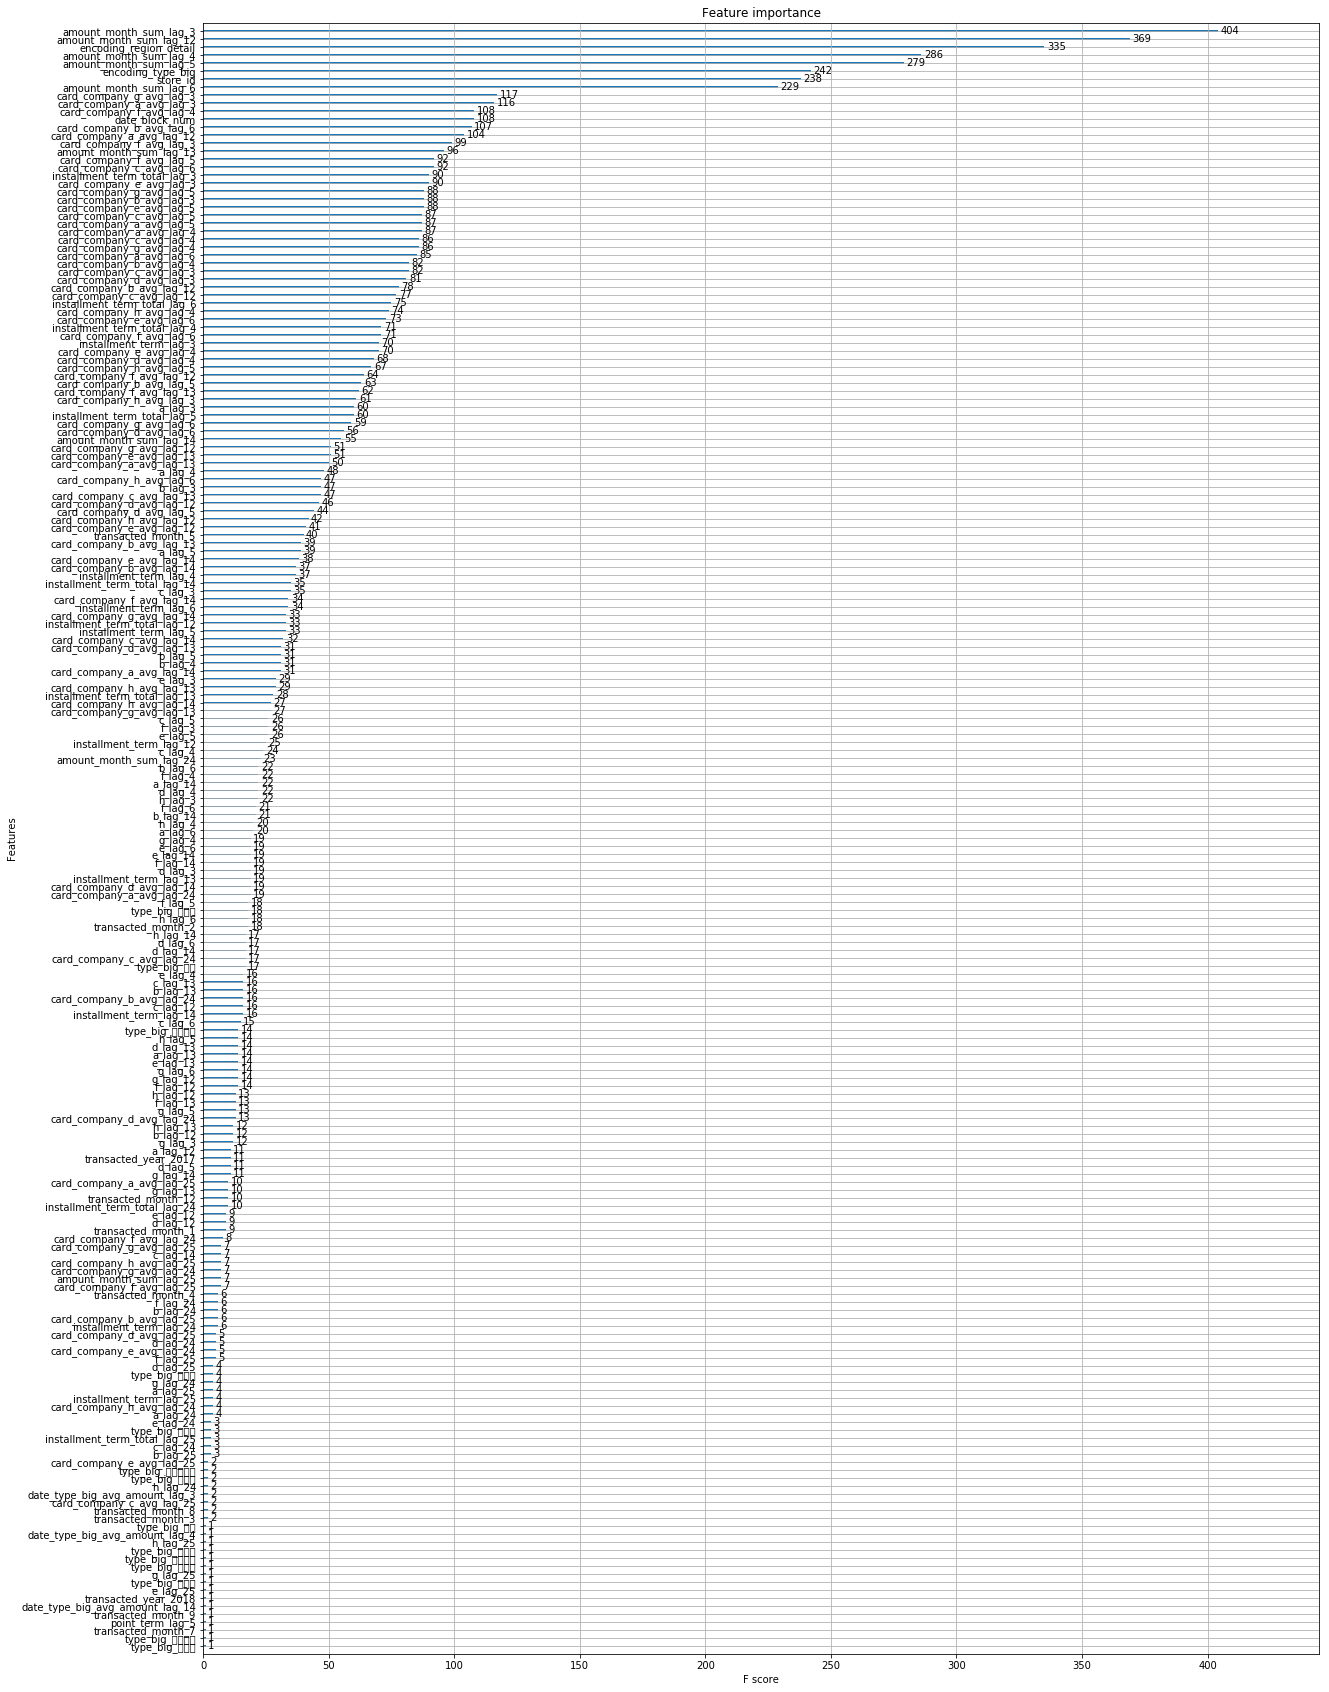

In [294]:
import matplotlib.pyplot as plt
from xgboost import plot_importance
def plot_features(booster, figsize):
    fig, ax = plt.subplots(1, 1, figsize=figsize)
    return plot_importance(booster=booster, ax=ax)
plot_features(model, (20,30))
plt.show()

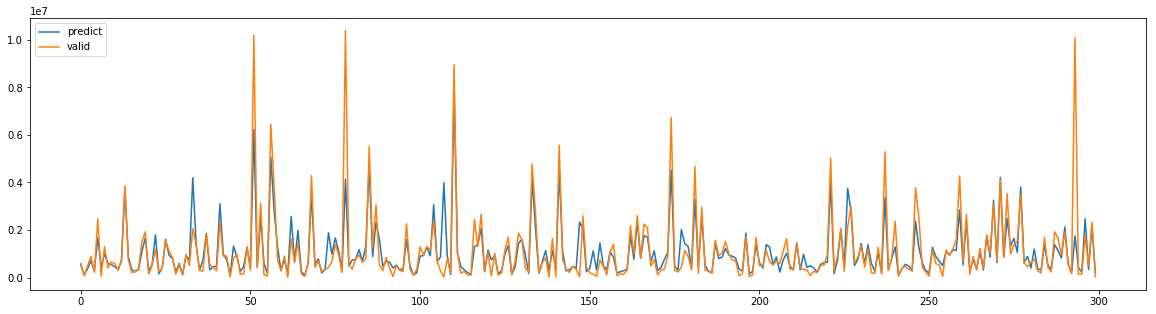

In [287]:
import matplotlib.pyplot as plt
plt.figure(figsize=(20, 5))
plt.plot(list(model.predict(X_valid[:300])), label='predict')
plt.plot(list(Y_valid[:300]), label='valid')
plt.legend()
plt.show()

In [291]:
rs_33 = model.predict(matrix[matrix.date_block_num == 33].drop(['amount_month_sum'], axis=1))
rs_34 = model.predict(matrix[matrix.date_block_num == 34].drop(['amount_month_sum'], axis=1))
rs_35 = model.predict(matrix[matrix.date_block_num == 35].drop(['amount_month_sum'], axis=1))
#rs = np.expm1(rs_33) + np.expm1(rs_34) + np.expm1(rs_35)
rs = rs_33 + rs_34 + rs_35

In [292]:
submission = pd.read_csv('../input/submission.csv')
submission['amount'] = rs
submission.head()

,store_id,amount
0,0,1.826105e+06
1,1,3.657516e+05
2,2,1.103034e+06
3,4,2.335382e+06
4,5,1.010115e+06


In [293]:
submission.to_csv('baseline_submission_final.csv', index=False)